## Creating CSV annotations

In [48]:
import pandas as pd
import os

In [49]:
df = pd.read_csv("test.csv")

In [23]:
for filename, group in df.groupby("filename"):
    csvname = filename.split('.')[0] + '.csv'
    group.to_csv(os.path.join("BCCD/CSVAnnotations", csvname), index=False)

## Experimenting with opencv

In [44]:
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

imagePath = "BCCD/JPEGImages"
csvPath = "BCCD/CSVAnnotations"

# red blood cells are red, platelets green, white blood cells are blue
colors = {'RBC': (255,0,0), 'Platelets': (0,255,0), 'WBC': (0,0,255)}

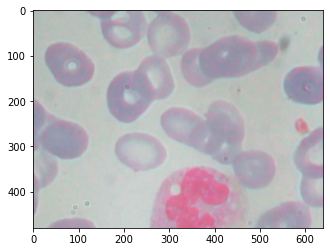

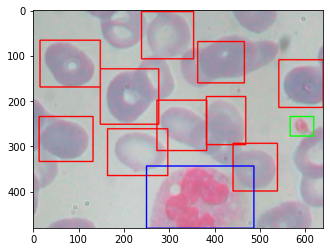

In [90]:
# Show example image and the objects
fileNum = "315"
jpgFile = "BloodImage_00" + fileNum + ".jpg"
csvFile = "BloodImage_00" + fileNum + ".csv"
img = cv2.imread(os.path.join(imagePath, jpgFile))
plt.imshow(img)

objects = pd.read_csv(os.path.join(csvPath, csvFile))
for i, row in objects.iterrows():
    filename, cell_type, xmin, xmax, ymin, ymax = row
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), colors[cell_type], 2)
plt.figure()
plt.imshow(img)

1251


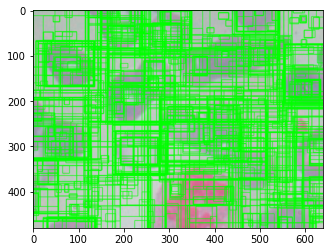

In [91]:
cv2.setUseOptimized(True);
# draw all bounding boxes produced by selective search
img = cv2.imread(os.path.join(imagePath, jpgFile))
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imgOut = img.copy()
print(len(rects))
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imgOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(imgOut)

In [54]:
# Calculate intersection/union ratio
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [110]:
IMG_SIZE = 224

In [102]:
# Create our training set from the proposed regions. For each image take at most MAXCOUNT each
# of positive and negative samples to make an even training set
MAXCOUNT = 30

labels = {'WBC': 2, 'RBC': 1, 'Platelets': 0}

train_images=[]
train_labels=[]

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
for i, filename in enumerate(os.listdir(imagePath)):
    print(i, filename)
    csvName = filename.split(".")[0]+".csv"
    image = cv2.imread(os.path.join(imagePath, filename))
    objectsDf = pd.read_csv(os.path.join(csvPath, csvName))
    objects = []
    for idx, row in objectsDf.iterrows():
        filename, cell_type, xmin, xmax, ymin, ymax = row
        if xmin < xmax and ymin < ymax:
            objects.append({"x1": xmin, "x2": xmax, "y1": ymin, "y2": ymax, "label": cell_type})
        
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    imgout = image.copy()
    
    trueCount = 0
    falseCount = 0
    for (x,y,w,h) in rects[:min(2000, len(rects))]:
        rect = {"x1": x, "x2": x+w, "y1": y, "y2": y+h}
        if trueCount < MAXCOUNT or falseCount < MAXCOUNT:
            for obj in objects:
                iou = get_iou(obj, rect)
                if trueCount < MAXCOUNT and iou > 0.7:
                    resized = cv2.resize(imgout[y:y+h,x:x+w], (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA)
                    train_images.append(resized)
                    train_labels.append(labels[obj['label']])
                    trueCount += 1

                if falseCount < MAXCOUNT and iou < 0.3:
                    resized = cv2.resize(imout[y:y+h,x:x+w], (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA)
                    train_images.append(resized)
                    train_labels.append(labels[obj['label']])
                    falseCount += 1
        else:
            break
    print(trueCount, falseCount)

0 BloodImage_00315.jpg
15 30
1 BloodImage_00301.jpg
30 30
2 BloodImage_00117.jpg
2 30
3 BloodImage_00103.jpg
8 30
4 BloodImage_00063.jpg
9 30
5 BloodImage_00077.jpg
6 30
6 BloodImage_00088.jpg
4 30
7 BloodImage_00249.jpg
1 30
8 BloodImage_00261.jpg
30 30
9 BloodImage_00275.jpg
24 30
10 BloodImage_00274.jpg


KeyboardInterrupt: 

In [64]:
xTrain = np.array(train_images)
yTrain = np.array(train_labels)

In [105]:
print("Dataset shape: {}".format(xTrain.shape))
print("Label shape: {}".format(yTrain.shape))

Dataset shape: (20049, 224, 224, 3)
Label shape: (20049,)


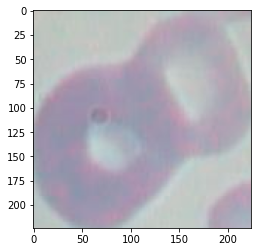

In [97]:
plt.imshow(xTrain[0])

## Training model

Referring to https://github.com/ByeongGil-Jung/Keras-CNN-RGB-Images/blob/master/src/d2_keras.ipynb

In [111]:
import keras

In [112]:
num_classes = 3
labels_one_hot = keras.utils.to_categorical(yTrain, 3)

In [114]:
xTrain = xTrain.astype("float32")

In [118]:
xTrain /= 255.

In [119]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(xTrain, labels_one_hot, test_size=0.1)

In [142]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

In [143]:
model = Sequential()

model.add(Conv2D(32, (5, 5), padding="same", activation="relu", input_shape=x_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2), padding="same"))

model.add(Conv2D(32, (5, 5), activation="relu", strides=(2,2), padding="same"))
model.add(MaxPooling2D(pool_size=(2), padding="same"))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(124, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(124, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax"))

In [144]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 64)       

In [147]:
epochs = 5
batch_size = 128
lr = 0.0001
decay = 1e-6

optimizer = keras.optimizers.RMSprop(lr=lr, decay=decay)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(
    x_train, 
    y_train, 
    batch_size=batch_size, 
    epochs=epochs, validation_data=(x_test, y_test), 
    shuffle=True, 
    verbose=1
)

Train on 18044 samples, validate on 2005 samples
Epoch 1/5
 8704/18044 [=============>................] - ETA: 3:29 - loss: 0.5104 - accuracy: 0.8589